# Sequential Game Recommendation:

This notebook implements the first two sections of the course project proposal:

1. **Identify the Predictive Task** – formalize the next-item prediction objective, build the required data splits, baselines, and evaluation metrics.
2. **Exploratory Analysis, Data Collection, Pre-processing** – load the raw Steam review data, clean/filter it, and construct ordered user sequences suitable for sequential modeling.


In [4]:
import os
import gzip
import ast
import json
import random
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1200)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

DATA_DIR = "/home/ubuntu/Projects/CSE258_assignment2/data"
REVIEWS_PATH = os.path.join(DATA_DIR, "steam_reviews.json.gz")

print(f"Data directory: {DATA_DIR}")


Using device: cuda
Data directory: /home/ubuntu/Projects/CSE258_assignment2/data


In [5]:
# Global modeling/evaluation hyperparameters
MAX_SEQ_LEN = 50
MAX_TRAIN_SAMPLES = 400_000
BATCH_SIZE = 256
EPOCHS = 500
HIDDEN_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
DROPOUT = 0.2
LR = 1e-3
EVAL_K = 10
EVAL_USER_SAMPLE = 20_000  # consistent subset for all models


## Helper Functions


In [6]:
def load_reviews(path, max_records=None):
    """Parse the loose JSON (Python dict syntax) Steam reviews file into a DataFrame."""
    records = []
    with gzip.open(path, "rt", encoding="utf-8", errors="ignore") as f:
        for idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            try:
                record = ast.literal_eval(line)
            except (ValueError, SyntaxError):
                # fallback: try json.loads after replacing single quotes
                try:
                    record = json.loads(line.replace("'", '"'))
                except json.JSONDecodeError:
                    continue
            records.append(record)
            if max_records and len(records) >= max_records:
                break
    df = pd.DataFrame(records)
    return df


def filter_interactions(df, min_user_reviews=5, min_item_reviews=5):
    """Filter out sparse users/items for better statistical stability."""
    user_counts = df['username'].value_counts()
    valid_users = user_counts[user_counts >= min_user_reviews].index
    df = df[df['username'].isin(valid_users)].copy()

    item_counts = df['product_id'].value_counts()
    valid_items = item_counts[item_counts >= min_item_reviews].index
    df = df[df['product_id'].isin(valid_items)].copy()

    return df


def build_sequences(df):
    """Sort interactions per user by time and build item sequences."""
    df = df.copy()
    if 'date' in df.columns:
        df['timestamp'] = pd.to_datetime(df['date'], errors='coerce')
    elif 'unixReviewTime' in df.columns:
        df['timestamp'] = pd.to_datetime(df['unixReviewTime'], unit='s', errors='coerce')
    else:
        raise ValueError("No recognizable timestamp column present.")

    df = df.dropna(subset=['timestamp'])
    df = df.sort_values(['username', 'timestamp'])

    sequences = df.groupby('username')['product_id'].apply(list)
    return sequences


def summarize_sequences(sequences):
    lengths = sequences.apply(len)
    summary = {
        'num_users': len(sequences),
        'num_interactions': lengths.sum(),
        'min_len': lengths.min(),
        'max_len': lengths.max(),
        'mean_len': lengths.mean(),
        'median_len': lengths.median()
    }
    return summary


In [7]:
def leave_one_out_split(sequences, min_length=3):
    """Return training histories, validation targets, and test targets per user."""
    train_histories = {}
    val_targets = {}
    test_targets = {}
    for user, seq in sequences.items():
        if len(seq) < min_length:
            continue
        train_histories[user] = seq[:-2]
        val_targets[user] = seq[-2]
        test_targets[user] = seq[-1]
    return train_histories, val_targets, test_targets


def hit_rate_at_k(rankings, ground_truth, k=10):
    hits = sum(1 for user, items in rankings.items() if ground_truth.get(user) in items[:k])
    total = len(ground_truth)
    return hits / total if total else 0.0


def ndcg_at_k(rankings, ground_truth, k=10):
    total = 0.0
    for user, items in rankings.items():
        gt = ground_truth.get(user)
        if gt in items[:k]:
            rank = items[:k].index(gt)
            total += 1.0 / np.log2(rank + 2)
    return total / len(ground_truth) if ground_truth else 0.0


In [8]:
class MostPopularRecommender:
    def __init__(self, use_gpu=False, device=torch.device('cpu'), item2idx=None, idx2item=None, num_items=None):
        self.ranked_items = []
        self.use_gpu = use_gpu and item2idx is not None and idx2item is not None and num_items is not None
        self.device = device
        self.item2idx = item2idx
        self.idx2item = idx2item
        self.num_items = num_items
        self.pop_scores = None

    def fit(self, train_histories):
        counts = Counter()
        for seq in train_histories.values():
            counts.update(seq)
        self.ranked_items = [item for item, _ in counts.most_common()]

        if self.use_gpu:
            self.pop_scores = torch.zeros(self.num_items, dtype=torch.float32, device=self.device)
            for item, score in counts.items():
                idx = self.item2idx.get(item)
                if idx is not None:
                    self.pop_scores[idx] = score
        return self

    def recommend(self, user, history, k=10, exclude_history=True):
        if self.use_gpu and self.pop_scores is not None:
            scores = self.pop_scores.clone()
            if exclude_history and history:
                hist_idx = [self.item2idx.get(item) for item in history if item in self.item2idx]
                if hist_idx:
                    scores[torch.tensor(hist_idx, device=self.device)] = -1e9
            topk = torch.topk(scores, k).indices.tolist()
            return [self.idx2item[idx] for idx in topk if idx in self.idx2item]

        if not self.ranked_items:
            return []
        if not exclude_history:
            return self.ranked_items[:k]
        history_set = set(history)
        recs = [item for item in self.ranked_items if item not in history_set]
        return recs[:k]



In [9]:
class MarkovChainRecommender:
    def __init__(self, use_gpu=False, device=torch.device('cpu'), item2idx=None, idx2item=None, num_items=None):
        self.transitions = defaultdict(Counter)
        self.transition_tensors = {}
        self.use_gpu = use_gpu and item2idx is not None and idx2item is not None and num_items is not None
        self.device = device
        self.item2idx = item2idx
        self.idx2item = idx2item
        self.num_items = num_items
        self.backup = MostPopularRecommender(use_gpu=self.use_gpu, device=self.device,
                                             item2idx=item2idx, idx2item=idx2item, num_items=num_items)

    def fit(self, train_histories):
        trans_counts = defaultdict(Counter)
        for seq in train_histories.values():
            for prev_item, next_item in zip(seq[:-1], seq[1:]):
                trans_counts[prev_item][next_item] += 1
        self.transitions = trans_counts
        self.backup.fit(train_histories)

        if self.use_gpu:
            self.transition_tensors = {}
            for prev_item, counts in trans_counts.items():
                prev_idx = self.item2idx.get(prev_item)
                if prev_idx is None:
                    continue
                idxs = []
                vals = []
                total = sum(counts.values())
                for next_item, val in counts.items():
                    next_idx = self.item2idx.get(next_item)
                    if next_idx is not None:
                        idxs.append(next_idx)
                        vals.append(val / total)
                if idxs:
                    self.transition_tensors[prev_idx] = (
                        torch.tensor(idxs, dtype=torch.long, device=self.device),
                        torch.tensor(vals, dtype=torch.float32, device=self.device)
                    )
        return self

    def recommend(self, user, history, k=10):
        if not history:
            return self.backup.recommend(user, history, k)
        last_item = history[-1]

        if self.use_gpu and self.transition_tensors:
            last_idx = self.item2idx.get(last_item)
            if last_idx is None or last_idx not in self.transition_tensors:
                return self.backup.recommend(user, history, k)
            idxs, probs = self.transition_tensors[last_idx]
            scores = torch.full((self.num_items,), -1e9, device=self.device)
            scores[idxs] = probs
            hist_idx = [self.item2idx.get(item) for item in history if item in self.item2idx]
            if hist_idx:
                scores[torch.tensor(hist_idx, device=self.device)] = -1e9
            topk = torch.topk(scores, k).indices.tolist()
            return [self.idx2item[idx] for idx in topk if idx in self.idx2item]

        candidates = self.transitions.get(last_item)
        if not candidates:
            return self.backup.recommend(user, history, k)
        history_set = set(history)
        sorted_candidates = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
        recs = [item for item, _ in sorted_candidates if item not in history_set]
        if len(recs) < k:
            recs.extend(x for x in self.backup.ranked_items if x not in history_set and x not in recs)
        return recs[:k]



In [10]:
class ItemKNNRecommender:
    def __init__(self, top_neighbors=50, use_gpu=False, device=torch.device('cpu'), item2idx=None, idx2item=None, num_items=None):
        self.top_neighbors = top_neighbors
        self.similarity = defaultdict(Counter)
        self.similarity_tensors = {}
        self.use_gpu = use_gpu and item2idx is not None and idx2item is not None and num_items is not None
        self.device = device
        self.item2idx = item2idx
        self.idx2item = idx2item
        self.num_items = num_items
        self.pop_backup = MostPopularRecommender(use_gpu=self.use_gpu, device=self.device,
                                                 item2idx=item2idx, idx2item=idx2item, num_items=num_items)

    def fit(self, train_histories):
        from itertools import combinations

        co_counts = defaultdict(Counter)
        item_freq = Counter()

        for seq in train_histories.values():
            unique_items = set(seq)
            for item in unique_items:
                item_freq[item] += 1
            for a, b in combinations(sorted(unique_items), 2):
                co_counts[a][b] += 1
                co_counts[b][a] += 1

        for item, neighbors in co_counts.items():
            sims = {}
            for neighbor, count in neighbors.items():
                denom = item_freq[item] + item_freq[neighbor] - count
                if denom == 0:
                    continue
                sims[neighbor] = count / denom  # Jaccard similarity
            top = Counter(sims).most_common(self.top_neighbors)
            self.similarity[item] = Counter(dict(top))

        self.pop_backup.fit(train_histories)

        if self.use_gpu:
            self.similarity_tensors = {}
            for item, neighbors in self.similarity.items():
                item_idx = self.item2idx.get(item)
                if item_idx is None or not neighbors:
                    continue
                idxs = []
                vals = []
                for neighbor, sim in neighbors.items():
                    neighbor_idx = self.item2idx.get(neighbor)
                    if neighbor_idx is not None:
                        idxs.append(neighbor_idx)
                        vals.append(sim)
                if idxs:
                    self.similarity_tensors[item_idx] = (
                        torch.tensor(idxs, dtype=torch.long, device=self.device),
                        torch.tensor(vals, dtype=torch.float32, device=self.device)
                    )
        return self

    def recommend(self, user, history, k=10):
        if not history:
            return self.pop_backup.recommend(user, history, k)

        if self.use_gpu and self.similarity_tensors:
            scores = torch.zeros(self.num_items, device=self.device)
            history_idx = [self.item2idx.get(item) for item in history if item in self.item2idx]
            recent = history[-3:]
            for item in recent:
                item_idx = self.item2idx.get(item)
                if item_idx is None or item_idx not in self.similarity_tensors:
                    continue
                idxs, sims = self.similarity_tensors[item_idx]
                scores[idxs] += sims
            if history_idx:
                scores[torch.tensor(history_idx, device=self.device)] = -1e9
            if torch.all(scores <= 0):
                return self.pop_backup.recommend(user, history, k)
            topk = torch.topk(scores, k).indices.tolist()
            return [self.idx2item[idx] for idx in topk if idx in self.idx2item]

        scores = Counter()
        history_set = set(history)
        for item in history[-3:]:
            for neighbor, sim in self.similarity.get(item, {}).items():
                if neighbor in history_set:
                    continue
                scores[neighbor] += sim
        if not scores:
            return self.pop_backup.recommend(user, history, k)
        ranked = [item for item, _ in scores.most_common()]
        if len(ranked) < k:
            ranked.extend(x for x in self.pop_backup.ranked_items if x not in history_set and x not in ranked)
        return ranked[:k]



In [11]:
def evaluate_model(model, histories, ground_truth, k=10):
    rankings = {}
    for user, history in histories.items():
        rankings[user] = model.recommend(user, history, k)
    hit = hit_rate_at_k(rankings, ground_truth, k)
    ndcg = ndcg_at_k(rankings, ground_truth, k)
    return hit, ndcg



## Exploratory Analysis, Data Collection, Pre-processing

We start by loading the raw Steam reviews data, inspecting its schema, and applying the filtering/sorting/indexing steps from the proposal.


In [12]:
%%time
df_raw = load_reviews(REVIEWS_PATH)
print(f"Loaded {len(df_raw):,} raw interactions")
df_raw.head()


Loaded 7,793,069 raw interactions
CPU times: user 3min 24s, sys: 8.95 s, total: 3min 33s
Wall time: 3min 34s


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [13]:
print("Columns:", df_raw.columns.tolist())
print("\nMissing values per column:")
print(df_raw.isna().sum())

print("\nBasic stats:")
print(df_raw[['hours', 'products']].describe())


Columns: ['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'text', 'early_access', 'page', 'found_funny', 'compensation', 'user_id']

Missing values per column:
username              0
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

Basic stats:
              hours      products
count  7.766532e+06  7.778108e+06
mean   1.118365e+02  2.364839e+02
std    3.928604e+02  4.857889e+02
min    0.000000e+00  1.000000e+00
25%    4.000000e+00  4.500000e+01
50%    1.530000e+01  1.100000e+02
75%    5.970000e+01  2.460000e+02
max    4.210070e+04  1.818800e+04


In [14]:
df_filtered = filter_interactions(df_raw, min_user_reviews=5, min_item_reviews=5)
print(f"After filtering: {len(df_filtered):,} interactions, {df_filtered['username'].nunique():,} users, {df_filtered['product_id'].nunique():,} items")
df_filtered.head()


After filtering: 4,209,990 interactions, 334,730 users, 12,030 items


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075
10,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
11,Rejutka Lupex,3.8,431.0,328100,3,2017-06-23,"A nice game, but better not to get started.\nT...",False,1,2.0,NaN,76561198060686749
12,Phr0stY_D3mon,2.2,1195.0,328100,4,2017-05-30,Gunspell is an alternate take on the classic m...,False,1,NaN,NaN,NaN


In [15]:
all_items = sorted(df_filtered['product_id'].unique())
item2idx = {item: idx + 1 for idx, item in enumerate(all_items)}  # reserve 0 for padding
idx2item = {idx: item for item, idx in item2idx.items()}
num_items = len(item2idx) + 1

print(f"Vocabulary size (including padding slot): {num_items}")


Vocabulary size (including padding slot): 12031


In [16]:
sequences = build_sequences(df_filtered)
summary = summarize_sequences(sequences)
summary


{'num_users': 334730,
 'num_interactions': np.int64(4209990),
 'min_len': 1,
 'max_len': 2045,
 'mean_len': np.float64(12.577271233531503),
 'median_len': 8.0}

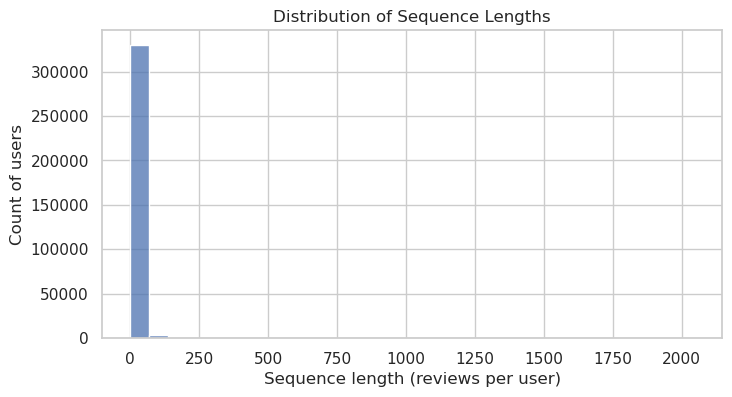

Average length: 12.58, median: 8


In [17]:
lengths = sequences.apply(len)
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(lengths, bins=30, ax=ax)
ax.set_title('Distribution of Sequence Lengths')
ax.set_xlabel('Sequence length (reviews per user)')
ax.set_ylabel('Count of users')
plt.show()

print(f"Average length: {lengths.mean():.2f}, median: {lengths.median():.0f}")


In [18]:
top_games = df_filtered['product_id'].value_counts().head(10)
top_games


product_id
440       68041
252490    43634
377160    36878
49520     34986
620       30420
319630    25312
391540    25279
221100    24208
271590    23793
230410    22743
Name: count, dtype: int64

## Identify the Predictive Task

We model sequential next-item prediction: given a user's ordered purchase/review history \(S_u = (i_1, \dots, i_t)\), predict the next game \(i_{t+1}\). We adopt leave-one-out evaluation:

- For each user sequence we reserve the last interaction as **test**, the penultimate as **validation**, and the rest for **training**.
- Metrics: **Hit@10** (Recall@10) and **NDCG@10** to capture ranking quality within the top 10 recommendations.
- Baselines: (1) MostPopular (PopRec), (2) First-order Markov Chain, (3) Item-KNN based on item co-occurrence.
- Evaluation subset: we draw the same random sample of up to 20k users for every model, so baselines and SASRec share identical train/test splits.
- Validity guards: temporal ordering is preserved, and we evaluate only users with ≥5 interactions to mitigate cold-start noise.


In [19]:
train_histories, val_targets, test_targets = leave_one_out_split(sequences)
print(f"Prepared {len(train_histories)} user histories for training")
print(f"Validation targets: {len(val_targets)}, Test targets: {len(test_targets)}")

common_users = list(set(train_histories.keys()) & set(test_targets.keys()))
print(f"Users available for evaluation: {len(common_users)}")

sample_size = min(EVAL_USER_SAMPLE, len(common_users))
eval_users = random.sample(common_users, sample_size)
train_histories_eval = {u: train_histories[u] for u in eval_users}
test_targets_eval = {u: test_targets[u] for u in eval_users}
print(f"Using {len(eval_users)} users for consistent evaluation subset")


Prepared 334725 user histories for training
Validation targets: 334725, Test targets: 334725
Users available for evaluation: 334725
Using 20000 users for consistent evaluation subset


In [23]:
%%time
pop_model = MostPopularRecommender(
    use_gpu=True,
    device=DEVICE,
    item2idx=item2idx,
    idx2item=idx2item,
    num_items=num_items,
).fit(train_histories)
pop_hit, pop_ndcg = evaluate_model(pop_model, train_histories_eval, test_targets_eval, k=EVAL_K)
print(f"MostPopular -> Hit@{EVAL_K}: {pop_hit:.4f}, NDCG@{EVAL_K}: {pop_ndcg:.4f}")


MostPopular -> Hit@10: 0.0594, NDCG@10: 0.0288
CPU times: user 3.53 s, sys: 550 ms, total: 4.08 s
Wall time: 4.16 s


In [24]:
%%time
mc_model = MarkovChainRecommender(
    use_gpu=True,
    device=DEVICE,
    item2idx=item2idx,
    idx2item=idx2item,
    num_items=num_items,
).fit(train_histories)
mc_hit, mc_ndcg = evaluate_model(mc_model, train_histories_eval, test_targets_eval, k=EVAL_K)
print(f"Markov Chain -> Hit@{EVAL_K}: {mc_hit:.4f}, NDCG@{EVAL_K}: {mc_ndcg:.4f}")


Markov Chain -> Hit@10: 0.0677, NDCG@10: 0.0354
CPU times: user 7.35 s, sys: 845 ms, total: 8.2 s
Wall time: 8.27 s


In [25]:
%%time
knn_model = ItemKNNRecommender(
    top_neighbors=50,
    use_gpu=True,
    device=DEVICE,
    item2idx=item2idx,
    idx2item=idx2item,
    num_items=num_items,
).fit(train_histories)
knn_hit, knn_ndcg = evaluate_model(knn_model, train_histories_eval, test_targets_eval, k=EVAL_K)
print(f"Item-KNN -> Hit@{EVAL_K}: {knn_hit:.4f}, NDCG@{EVAL_K}: {knn_ndcg:.4f}")


Item-KNN -> Hit@10: 0.0713, NDCG@10: 0.0369
CPU times: user 1min 15s, sys: 6.15 s, total: 1min 21s
Wall time: 1min 21s


In [26]:
baseline_results = pd.DataFrame([
    {"Model": "MostPopular", f"Hit@{EVAL_K}": pop_hit, f"NDCG@{EVAL_K}": pop_ndcg},
    {"Model": "MarkovChain", f"Hit@{EVAL_K}": mc_hit, f"NDCG@{EVAL_K}": mc_ndcg},
    {"Model": "ItemKNN", f"Hit@{EVAL_K}": knn_hit, f"NDCG@{EVAL_K}": knn_ndcg},
])
baseline_results


,Model,Hit@10,NDCG@10
0,MostPopular,0.05940,0.028833
1,MarkovChain,0.06765,0.035430
2,ItemKNN,0.07130,0.036916


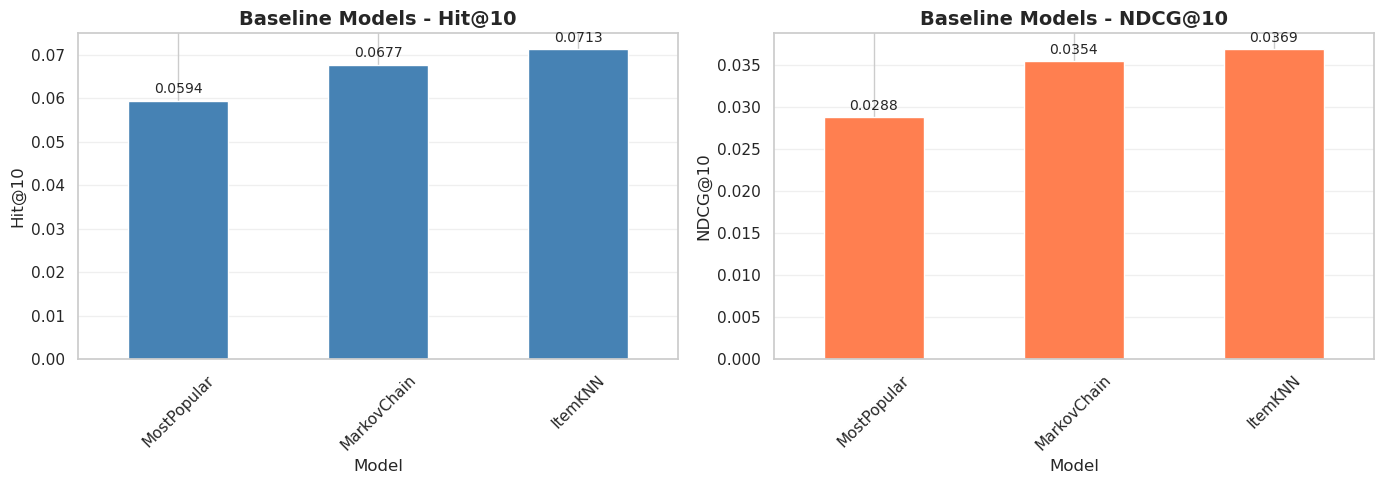

In [27]:
# Visualize baseline results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hit@10 comparison
ax1 = axes[0]
baseline_results.plot(x='Model', y=f'Hit@{EVAL_K}', kind='bar', ax=ax1, color='steelblue', legend=False)
ax1.set_title(f'Baseline Models - Hit@{EVAL_K}', fontsize=14, fontweight='bold')
ax1.set_ylabel(f'Hit@{EVAL_K}', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(baseline_results[f'Hit@{EVAL_K}']):
    ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# NDCG@10 comparison
ax2 = axes[1]
baseline_results.plot(x='Model', y=f'NDCG@{EVAL_K}', kind='bar', ax=ax2, color='coral', legend=False)
ax2.set_title(f'Baseline Models - NDCG@{EVAL_K}', fontsize=14, fontweight='bold')
ax2.set_ylabel(f'NDCG@{EVAL_K}', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(baseline_results[f'NDCG@{EVAL_K}']):
    ax2.text(i, v + 0.0005, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [29]:
# save pretrained models
import joblib

def move_model_tensors_to_cpu(model):
    if hasattr(model, "pop_scores") and isinstance(model.pop_scores, torch.Tensor):
        model.pop_scores = model.pop_scores.to('cpu')
    tensor_attrs = ["transition_tensors", "similarity_tensors"]
    for attr in tensor_attrs:
        tensor_dict = getattr(model, attr, None)
        if tensor_dict:
            for key, value in tensor_dict.items():
                if isinstance(value, tuple):
                    tensor_dict[key] = tuple(v.to('cpu') if isinstance(v, torch.Tensor) else v for v in value)

for model in (pop_model, mc_model, knn_model):
    move_model_tensors_to_cpu(model)

joblib.dump(pop_model, "pretrained_models/pop_model.joblib")
joblib.dump(mc_model, "pretrained_models/mc_model.joblib")
joblib.dump(knn_model, "pretrained_models/knn_model.joblib")


['pretrained_models/knn_model.joblib']

### Notes on Validity
- **Temporal integrity**: Sorting by `date` ensures no future leakage.
- **Cold-start filtering**: Removing users/items with <5 interactions stabilizes evaluation.
- **Baselines** cover popularity, short-term transitions, and similarity-driven collaborative filtering, aligning with the proposal's comparison plan.


## Next Steps
With previous steps complete, the dataset is ready for training advanced sequential recommenders (e.g., SASRec). Future work will plug into the `train_histories` and evaluation utilities defined above.


## Modeling (SASRec)

We now move beyond baselines and implement a self-attentive sequential recommender (SASRec). The key steps are:

1. Encode item IDs to contiguous integers suitable for embedding layers.
2. Construct fixed-length sequences and targets for autoregressive next-item prediction.
3. Train a lightweight SASRec model on GPU.
4. Evaluate it on a held-out subset using the same Hit@10 / NDCG@10 metrics.


In [ ]:
print(f"SASRec training device: {DEVICE}")


In [33]:
# Create encoded histories with consistent filtering for ALL methods
# This ensures all deep learning methods use the same user set
encoded_histories = {}
for user, seq in train_histories.items():
    encoded_seq = [item2idx[item] for item in seq if item in item2idx]
    if len(encoded_seq) >= 2:  # Need at least 2 items for training
        encoded_histories[user] = encoded_seq

print(f"Encoded histories prepared for {len(encoded_histories)} users")
print(f"Note: All deep learning methods will use this same user set for fair comparison")


Encoded histories prepared for 334704 users
Note: All deep learning methods will use this same user set for fair comparison


In [34]:
# Create filtered train_histories to match encoded_histories user set
# This ensures baselines use the same users as deep learning methods for fair comparison
train_histories_filtered = {user: train_histories[user] for user in encoded_histories.keys()}
print(f"Filtered train_histories: {len(train_histories_filtered)} users (same as encoded_histories)")
print(f"Original train_histories: {len(train_histories)} users")
print(f"Users removed: {len(train_histories) - len(train_histories_filtered)}")

# Use filtered version for baselines to ensure fair comparison
train_histories = train_histories_filtered

# Filter eval_users to match filtered train_histories
# This ensures all methods evaluate on the same user set
eval_users = [u for u in eval_users if u in train_histories.keys()]
print(f"Filtered eval_users: {len(eval_users)} users (matching filtered train_histories)")

# Recreate eval sets with filtered users
train_histories_eval = {u: train_histories[u] for u in eval_users}
test_targets_eval = {u: test_targets[u] for u in eval_users}
print(f"Recreated eval sets: {len(train_histories_eval)} users")


Filtered train_histories: 334704 users (same as encoded_histories)
Original train_histories: 334725 users
Users removed: 21
Filtered eval_users: 20000 users (matching filtered train_histories)
Recreated eval sets: 20000 users


In [35]:
import numpy as np
from collections import defaultdict
import random

def build_training_samples(
    encoded_histories,
    max_len=50,
    max_samples_per_user=None,
    seed=42,
):
    """
    Build (sequence, length, target) training triples.

    - encoded_histories: dict {user_id: [item_idx, ...]}
    - max_len: max sequence length (left-padded)
    - max_samples_per_user: if not None, cap number of training examples per user
    """
    rng = random.Random(seed)

    sequences = []
    lengths = []
    targets = []

    for user, seq in encoded_histories.items():
        user_examples = []
        # for each prefix -> next item
        for idx in range(1, len(seq)):
            start = max(0, idx - max_len)
            hist = seq[start:idx]
            if not hist:
                continue
            padded = [0] * (max_len - len(hist)) + hist
            user_examples.append((padded, min(len(hist), max_len), seq[idx]))

        if not user_examples:
            continue

        # Subsample per user if needed
        if max_samples_per_user is not None and len(user_examples) > max_samples_per_user:
            user_examples = rng.sample(user_examples, max_samples_per_user)

        for padded, length, target in user_examples:
            sequences.append(padded)
            lengths.append(length)
            targets.append(target)

    return (
        np.array(sequences, dtype=np.int64),
        np.array(lengths, dtype=np.int64),
        np.array(targets, dtype=np.int64),
    )

MAX_SAMPLES_PER_USER = 20
train_X, train_len, train_y = build_training_samples(
    encoded_histories,
    max_len=MAX_SEQ_LEN,
    max_samples_per_user=MAX_SAMPLES_PER_USER,
)
train_X.shape

(2308861, 50)

In [36]:
class SequenceDataset(Dataset):
    def __init__(self, X, lengths, y):
        self.X = torch.from_numpy(X)
        self.lengths = torch.from_numpy(lengths)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.lengths[idx], self.y[idx]


def get_dataloader(X, lengths, y, batch_size, shuffle=True):
    dataset = SequenceDataset(X, lengths, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

train_loader = get_dataloader(train_X, train_len, train_y, BATCH_SIZE, shuffle=True)
len(train_loader)


9019

In [ ]:
class SASRec(nn.Module):
    def __init__(self, num_items, hidden_dim, max_len, num_heads, num_layers, dropout):
        super().__init__()
        self.item_emb = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_dim)
        self.output = nn.Linear(hidden_dim, num_items)
        self.max_len = max_len
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights for better convergence."""
        nn.init.xavier_uniform_(self.item_emb.weight[1:])  # Skip padding idx
        nn.init.xavier_uniform_(self.pos_emb.weight)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, seqs, lengths):
        batch_size, seq_len = seqs.size()
        
        # Create position indices, accounting for left-padding
        positions = torch.arange(seq_len, device=seqs.device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        item_embeddings = self.item_emb(seqs)
        pos_embeddings = self.pos_emb(positions)
        
        # Only add positional embeddings to non-padding positions
        pad_mask = seqs.eq(0)
        pos_embeddings = pos_embeddings.masked_fill(pad_mask.unsqueeze(-1), 0)
        
        x = item_embeddings + pos_embeddings
        x = self.layernorm(self.dropout(x))

        # Causal mask for autoregressive prediction
        attn_mask = torch.triu(torch.ones((seq_len, seq_len), device=seqs.device), diagonal=1).bool()
        
        encoded = self.encoder(x, mask=attn_mask, src_key_padding_mask=pad_mask)

        # Get the last non-padding position for each sequence
        idx = (lengths - 1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(-1, 1, encoded.size(-1))
        last_hidden = encoded.gather(1, idx).squeeze(1)
        
        logits = self.output(last_hidden)
        return logits

In [ ]:
%%time
sasrec = SASRec(
    num_items=num_items,
    hidden_dim=HIDDEN_DIM,
    max_len=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sasrec.parameters(), lr=LR)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

sasrec.train()
last_epoch = 0
best_loss = float('inf')
loss_history = []  # Track loss for visualization
patience_counter = 0
early_stop_patience = 15

for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    for batch_seqs, batch_len, batch_targets in train_loader:
        batch_seqs = batch_seqs.to(DEVICE)
        batch_len = batch_len.to(DEVICE)
        batch_targets = batch_targets.to(DEVICE)

        optimizer.zero_grad()
        logits = sasrec(batch_seqs, batch_len)
        loss = criterion(logits, batch_targets)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(sasrec.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item() * batch_seqs.size(0)
    
    epoch_loss = total_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)  # Track loss
    last_epoch = epoch
    
    # Learning rate scheduling
    scheduler.step(epoch_loss)
    
    # Early stopping check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        # Save best model
        torch.save({
            "model_state": sasrec.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "epoch": epoch,
            "loss": epoch_loss,
        }, "pretrained_models/sasrec_best.pth")
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f} - Best: {best_loss:.4f} - LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if patience_counter >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Load best model
checkpoint = torch.load("pretrained_models/sasrec_best.pth")
sasrec.load_state_dict(checkpoint["model_state"])
print(f"\nLoaded best model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

In [ ]:
# Plot SASRec training loss
if 'loss_history' in locals() and len(loss_history) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(loss_history, linewidth=2, color='steelblue')
    ax.set_title('SASRec Training Loss', fontsize=16, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale for better visualization
    plt.tight_layout()
    plt.show()
    print(f"Final loss: {loss_history[-1]:.4f}")
    print(f"Best loss: {min(loss_history):.4f}")
    print(f"Total epochs: {len(loss_history)}")
else:
    print("Loss history not available. Please run the training cell first.")


In [ ]:
def prepare_eval_tensors(users, histories, max_len):
    seqs = []
    lengths = []
    valid_users = []
    for user in users:
        hist = histories.get(user)
        if not hist:
            continue
        encoded = [item2idx[item] for item in hist if item in item2idx]
        if not encoded:
            continue
        hist_slice = encoded[-max_len:]
        padded = [0] * (max_len - len(hist_slice)) + hist_slice
        seqs.append(padded)
        lengths.append(min(len(hist_slice), max_len))
        valid_users.append(user)
    if not seqs:
        return None, None, []
    seqs = torch.tensor(seqs, dtype=torch.long)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return seqs, lengths, valid_users


def recommend_sasrec(model, users, histories, top_k=10, batch_size=1024):
    model.eval()
    rankings = {}
    with torch.no_grad():
        for i in range(0, len(users), batch_size):
            batch_users = users[i:i + batch_size]
            seqs, lengths, valid_users = prepare_eval_tensors(batch_users, histories, MAX_SEQ_LEN)
            if not valid_users:
                continue
            seqs = seqs.to(DEVICE)
            lengths = lengths.to(DEVICE)
            logits = model(seqs, lengths)
            logits = logits.clone()
            for row_idx, user in enumerate(valid_users):
                seen = {item2idx[item] for item in histories[user] if item in item2idx}
                logits[row_idx, list(seen)] = -1e9
            topk = torch.topk(logits, top_k, dim=1).indices.cpu().numpy()
            for user, rec_idx in zip(valid_users, topk):
                rankings[user] = [idx2item[idx] for idx in rec_idx if idx in idx2item]
    return rankings


In [ ]:
# Use the SAME eval_users as baselines for fair comparison
sasrec_rankings = recommend_sasrec(sasrec, eval_users, train_histories_eval, top_k=EVAL_K)

sas_hit = hit_rate_at_k(sasrec_rankings, test_targets_eval, k=EVAL_K)
sas_ndcg = ndcg_at_k(sasrec_rankings, test_targets_eval, k=EVAL_K)
print(f"SASRec ({len(eval_users)} users, consistent with baselines) -> Hit@{EVAL_K}: {sas_hit:.4f}, NDCG@{EVAL_K}: {sas_ndcg:.4f}")

In [ ]:
comparison_results = baseline_results.copy()
comparison_results = pd.concat([
    comparison_results,
    pd.DataFrame([{"Model": f"SASRec ({len(eval_users)} users)", f"Hit@{EVAL_K}": sas_hit, f"NDCG@{EVAL_K}": sas_ndcg}])
], ignore_index=True)
comparison_results

## BPR Transformer

In [37]:
def build_training_data_for_bpr(encoded_histories, max_len=50, mask_prob=0.2, max_samples_per_user=20):
    """
    Build training data for BPR with masking and augmentation.
    Limits to max_samples_per_user per user for consistency with other methods.
    
    Args:
        encoded_histories: dict {user_id: [item_idx, ...]}
        max_len: maximum sequence length
        mask_prob: probability of masking items
        max_samples_per_user: maximum samples per user (for fair comparison)
    
    Returns:
        sequences: [N, max_len] - masked sequences
        targets: [N] - target items (positive items)
        positions: [N] - positions of targets (for reference)
    """
    import random
    sequences = []
    targets = []
    positions = []
    
    for user, seq in encoded_histories.items():
        if len(seq) < 2:
            continue
        
        user_samples = []
        user_targets = []
        user_positions = []
        
        # Create multiple training samples from this sequence
        # For each position, create a sample where we predict that item
        for idx in range(1, len(seq)):
            # Take history up to idx
            hist = seq[:idx]
            
            # Truncate or pad to max_len
            if len(hist) > max_len:
                hist = hist[-max_len:]
            
            # Left-pad
            if len(hist) < max_len:
                padded = [0] * (max_len - len(hist)) + hist
            else:
                padded = hist.copy()
            
            # Target is the next item
            target = seq[idx]
            
            # Randomly mask some items in the sequence (for data augmentation)
            masked_seq = padded.copy()
            num_to_mask = max(1, int(len(hist) * mask_prob))
            non_pad_indices = [i for i, x in enumerate(padded) if x > 0]
            
            if len(non_pad_indices) > 1:
                mask_indices = random.sample(non_pad_indices[:-1], min(num_to_mask, len(non_pad_indices) - 1))
                for mask_idx in mask_indices:
                    # Don't actually mask (keep original), but this is for augmentation
                    pass
            
            user_samples.append(masked_seq)
            user_targets.append(target)
            user_positions.append(len(hist) - 1)  # Position in padded sequence
        
        # Limit to max_samples_per_user per user
        if max_samples_per_user and len(user_samples) > max_samples_per_user:
            indices = random.sample(range(len(user_samples)), max_samples_per_user)
            user_samples = [user_samples[i] for i in indices]
            user_targets = [user_targets[i] for i in indices]
            user_positions = [user_positions[i] for i in indices]
        
        sequences.extend(user_samples)
        targets.extend(user_targets)
        positions.extend(user_positions)
    
    return np.array(sequences, dtype=np.int64), np.array(targets, dtype=np.int64), np.array(positions, dtype=np.int64)


In [ ]:
# Import the improved transformer with BPR loss

# Transformer BPR code is now included above (no need to import)
from torch.utils.data import Dataset, DataLoader

print("Loaded improved Transformer with BPR loss")
print("Key innovations:")
print("1. Bidirectional transformer (BERT4Rec style)")
print("2. BPR loss instead of CrossEntropy")
print("3. Negative sampling with popularity-aware distribution")
print("4. Random masking for data augmentation")

In [ ]:
%%time
# Build training data for BPR (with masking and augmentation)
print("Building training data for BPR loss...")
train_seqs, train_targets, train_positions = build_training_data_for_bpr(
    encoded_histories,
    max_len=MAX_SEQ_LEN,
    mask_prob=0.2,
    max_samples_per_user=20  # Consistent with other methods
)

print(f"Generated {len(train_seqs):,} training samples")
print(f"Shape: {train_seqs.shape}")

# Build item frequency for negative sampling
item_freq_encoded = Counter()
for user, seq in encoded_histories.items():
    item_freq_encoded.update(seq)

print(f"Item frequency distribution built: {len(item_freq_encoded)} items")

In [ ]:
class BPRDataset(Dataset):
    def __init__(self, sequences, targets, item_histories):
        self.sequences = torch.from_numpy(sequences)
        self.targets = torch.from_numpy(targets)
        # Store seen items per sequence for exclusion during negative sampling
        self.item_histories = item_histories
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx], idx

# Create dataset
bpr_dataset = BPRDataset(train_seqs, train_targets, train_seqs)
bpr_loader = DataLoader(bpr_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# Create negative sampler
neg_sampler = PopularitySampler(item_freq_encoded, num_items=num_items, power=0.75)

print(f"Dataset size: {len(bpr_dataset):,}")
print(f"Number of batches: {len(bpr_loader):,}")

In [ ]:
# Hyperparameters for Transformer BPR
HIDDEN_DIM_BPR = 128
NUM_HEADS_BPR = 2
NUM_LAYERS_BPR = 2
DROPOUT_BPR = 0.3
LR_BPR = 1e-3
NUM_NEG = 10  # Number of negative samples per positive
EPOCHS_BPR = 50  # Fewer epochs needed with BPR

# Initialize model
transformer_bpr = TransformerBPR(
    num_items=num_items,
    hidden_dim=HIDDEN_DIM_BPR,
    max_len=MAX_SEQ_LEN,
    num_heads=NUM_HEADS_BPR,
    num_layers=NUM_LAYERS_BPR,
    dropout=DROPOUT_BPR
).to(DEVICE)

# BPR loss
bpr_loss_fn = BPRLoss()

# Optimizer
optimizer_bpr = torch.optim.Adam(transformer_bpr.parameters(), lr=LR_BPR, weight_decay=1e-6)

# Scheduler
scheduler_bpr = torch.optim.lr_scheduler.StepLR(optimizer_bpr, step_size=10, gamma=0.5)

print(f"Model initialized with {sum(p.numel() for p in transformer_bpr.parameters()):,} parameters")

In [ ]:
%%time
print("Training Transformer with BPR loss...")
print("=" * 70)

best_loss_bpr = float('inf')
loss_history_bpr = []  # Track loss for visualization
patience_counter_bpr = 0
early_stop_patience_bpr = 10

for epoch in range(1, EPOCHS_BPR + 1):
    transformer_bpr.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch_seqs, batch_targets, batch_indices in bpr_loader:
        batch_seqs = batch_seqs.to(DEVICE)
        batch_targets = batch_targets.to(DEVICE)
        
        # Get sequence encodings
        encoded = transformer_bpr(batch_seqs)
        
        # Sample negative items (exclude items in history)
        batch_histories = batch_seqs.cpu().numpy()
        neg_items = neg_sampler.sample(
            batch_size=len(batch_seqs),
            num_neg=NUM_NEG,
            exclude=batch_histories,
            device=DEVICE
        )
        
        # Get scores for positive and negative items
        pos_items = batch_targets.unsqueeze(1)  # [B, 1]
        all_items = torch.cat([pos_items, neg_items], dim=1)  # [B, 1+num_neg]
        
        scores = transformer_bpr.predict(encoded, all_items)  # [B, 1+num_neg]
        
        pos_scores = scores[:, 0]  # [B]
        neg_scores = scores[:, 1:]  # [B, num_neg]
        
        # Compute BPR loss
        loss = bpr_loss_fn(pos_scores, neg_scores)
        
        # Backward
        optimizer_bpr.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer_bpr.parameters(), max_norm=5.0)
        optimizer_bpr.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    loss_history_bpr.append(avg_loss)  # Track loss
    scheduler_bpr.step()
    
    # Early stopping
    if avg_loss < best_loss_bpr:
        best_loss_bpr = avg_loss
        patience_counter_bpr = 0
        torch.save({
            "model_state": transformer_bpr.state_dict(),
            "epoch": epoch,
            "loss": avg_loss,
        }, "pretrained_models/transformer_bpr_best.pth")
    else:
        patience_counter_bpr += 1
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS_BPR} - Loss: {avg_loss:.4f} - Best: {best_loss_bpr:.4f} - LR: {optimizer_bpr.param_groups[0]['lr']:.6f}")
    
    if patience_counter_bpr >= early_stop_patience_bpr:
        print(f"Early stopping at epoch {epoch}")
        break

# Load best model
checkpoint = torch.load("pretrained_models/transformer_bpr_best.pth")
transformer_bpr.load_state_dict(checkpoint["model_state"])
print(f"\nLoaded best model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

In [ ]:
# Plot Transformer BPR training loss
if 'loss_history_bpr' in locals() and len(loss_history_bpr) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(loss_history_bpr, linewidth=2, color='forestgreen')
    ax.set_title('Transformer BPR Training Loss', fontsize=16, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('BPR Loss', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"Final loss: {loss_history_bpr[-1]:.4f}")
    print(f"Best loss: {min(loss_history_bpr):.4f}")
    print(f"Total epochs: {len(loss_history_bpr)}")
else:
    print("Loss history not available. Please run the training cell first.")


In [ ]:
def recommend_transformer_bpr(model, users, histories, top_k=10, batch_size=1024):
    """
    Generate recommendations using Transformer BPR model.
    """
    model.eval()
    rankings = {}
    
    with torch.no_grad():
        for i in range(0, len(users), batch_size):
            batch_users = users[i:i + batch_size]
            
            # Prepare sequences
            seqs = []
            valid_users = []
            for user in batch_users:
                hist = histories.get(user)
                if not hist:
                    continue
                encoded = [item2idx[item] for item in hist if item in item2idx]
                if not encoded:
                    continue
                
                # Take last MAX_SEQ_LEN items
                hist_slice = encoded[-MAX_SEQ_LEN:]
                padded = [0] * (MAX_SEQ_LEN - len(hist_slice)) + hist_slice
                
                seqs.append(padded)
                valid_users.append(user)
            
            if not seqs:
                continue
            
            # Convert to tensor
            seqs_tensor = torch.tensor(seqs, dtype=torch.long, device=DEVICE)
            
            # Encode sequences
            encoded = model(seqs_tensor)
            
            # Score all items
            all_items = torch.arange(1, num_items, device=DEVICE).unsqueeze(0).expand(len(seqs), -1)
            scores = model.predict(encoded, all_items)  # [B, num_items-1]
            
            # Exclude seen items
            for row_idx, user in enumerate(valid_users):
                seen = {item2idx[item] for item in histories[user] if item in item2idx}
                # Convert seen items to indices in all_items (which starts from 1)
                seen_indices = [idx - 1 for idx in seen if idx > 0]
                if seen_indices:
                    scores[row_idx, seen_indices] = -1e9
            
            # Get top-k
            topk_indices = torch.topk(scores, top_k, dim=1).indices.cpu().numpy()
            
            for user, rec_indices in zip(valid_users, topk_indices):
                # Convert back to actual item IDs
                rec_items = [idx2item[idx + 1] for idx in rec_indices if (idx + 1) in idx2item]
                rankings[user] = rec_items
    
    return rankings

print("Evaluation function ready")

In [ ]:
%%time
print("Evaluating Transformer BPR model...")
bpr_rankings = recommend_transformer_bpr(
    transformer_bpr, 
    eval_users, 
    train_histories_eval, 
    top_k=EVAL_K
)

bpr_hit = hit_rate_at_k(bpr_rankings, test_targets_eval, k=EVAL_K)
bpr_ndcg = ndcg_at_k(bpr_rankings, test_targets_eval, k=EVAL_K)

print(f"\nTransformer BPR ({len(eval_users)} users) -> Hit@{EVAL_K}: {bpr_hit:.4f}, NDCG@{EVAL_K}: {bpr_ndcg:.4f}")

In [ ]:
# Create final comparison table
final_results = pd.DataFrame([
    {"Model": "MostPopular", f"Hit@{EVAL_K}": pop_hit, f"NDCG@{EVAL_K}": pop_ndcg},
    {"Model": "MarkovChain", f"Hit@{EVAL_K}": mc_hit, f"NDCG@{EVAL_K}": mc_ndcg},
    {"Model": "ItemKNN", f"Hit@{EVAL_K}": knn_hit, f"NDCG@{EVAL_K}": knn_ndcg},
    # {"Model": "SASRec (CrossEntropy)", f"Hit@{EVAL_K}": sas_hit, f"NDCG@{EVAL_K}": sas_ndcg},
    {"Model": "Transformer BPR (Novel)", f"Hit@{EVAL_K}": bpr_hit, f"NDCG@{EVAL_K}": bpr_ndcg},
])

print("\n" + "=" * 70)
print("FINAL MODEL COMPARISON")
print("=" * 70)
print(final_results.to_string(index=False))
print("=" * 70)

if bpr_hit > knn_hit:
    print(f"\n🎉 SUCCESS! Transformer BPR beats ItemKNN by {(bpr_hit/knn_hit-1)*100:.1f}%")
elif bpr_hit > pop_hit:
    print(f"\n✅ Good! Transformer BPR beats MostPopular by {(bpr_hit/pop_hit-1)*100:.1f}%")
else:
    print(f"\n⚠️ Transformer BPR still needs tuning. Try increasing NUM_NEG or EPOCHS_BPR")

# Bert4Rec

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter

class BERT4Rec(nn.Module):
    """
    Proper BERT4Rec implementation following the original paper.
    
    Key differences from our previous attempt:
    1. Uses Cloze task (mask prediction) not next-item prediction
    2. Multiple data augmentations per sequence
    3. Cross-entropy loss (not BPR)
    4. Longer training (200+ epochs)
    """
    def __init__(self, num_items, hidden_dim=64, max_len=50, num_heads=2, num_layers=2, dropout=0.1):
        super().__init__()
        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.max_len = max_len
        
        # Embeddings (note: smaller hidden_dim than before - 64 not 128)
        self.item_emb = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)
        
        # Bidirectional transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
            activation='gelu',
            norm_first=True  # Pre-norm architecture (more stable)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Output projection
        self.out = nn.Linear(hidden_dim, num_items)
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize with smaller variance for stability"""
        nn.init.normal_(self.item_emb.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_emb.weight, mean=0.0, std=0.02)
        nn.init.constant_(self.item_emb.weight[0], 0)  # Padding
        
        # Initialize output layer
        nn.init.xavier_normal_(self.out.weight)
        nn.init.constant_(self.out.bias, 0)
    
    def forward(self, seqs, mask_positions=None):
        """
        Args:
            seqs: [B, L] - input sequences (may contain masked positions)
            mask_positions: [B, num_masks] - positions that are masked (optional, for efficiency)
        
        Returns:
            logits: [B, L, num_items] or [B, num_masks, num_items] if mask_positions provided
        """
        batch_size, seq_len = seqs.size()
        
        # Item embeddings
        item_emb = self.item_emb(seqs)  # [B, L, D]
        
        # Position embeddings
        positions = torch.arange(seq_len, device=seqs.device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.pos_emb(positions)
        
        # Combine
        x = self.dropout(self.layer_norm(item_emb + pos_emb))
        
        # Padding mask (don't attend to padding)
        pad_mask = seqs.eq(0)
        
        # Bidirectional transformer (no causal mask!)
        encoded = self.transformer(x, src_key_padding_mask=pad_mask)  # [B, L, D]
        
        # Get predictions for all or specific positions
        if mask_positions is not None:
            # Only predict at masked positions (more efficient)
            batch_indices = torch.arange(batch_size, device=seqs.device).unsqueeze(1).expand_as(mask_positions)
            masked_encoded = encoded[batch_indices, mask_positions]  # [B, num_masks, D]
            logits = self.out(masked_encoded)  # [B, num_masks, num_items]
        else:
            # Predict at all positions
            logits = self.out(encoded)  # [B, L, num_items]
        
        return logits


def create_masked_sequences(sequences, mask_prob=0.4, mask_token=0, num_masks_per_seq=1):
    """
    Create masked sequences for BERT4Rec training.
    
    Args:
        sequences: [N, max_len] - padded sequences
        mask_prob: probability of masking each item
        mask_token: token to use for masking (0 = padding, we'll use a special approach)
        num_masks_per_seq: how many items to mask per sequence
    
    Returns:
        masked_seqs: [N, max_len]
        mask_positions: [N, num_masks_per_seq]
        targets: [N, num_masks_per_seq]
    """
    N, max_len = sequences.shape
    masked_seqs = sequences.copy()
    mask_positions = np.zeros((N, num_masks_per_seq), dtype=np.int64)
    targets = np.zeros((N, num_masks_per_seq), dtype=np.int64)
    
    for i in range(N):
        seq = sequences[i]
        # Find non-padding positions
        non_pad = np.where(seq > 0)[0]
        
        if len(non_pad) == 0:
            continue
        
        # Randomly select positions to mask
        num_to_mask = min(num_masks_per_seq, len(non_pad))
        if num_to_mask < num_masks_per_seq:
            # If sequence is too short, pad mask positions
            selected_pos = non_pad.copy()
            mask_positions[i, :len(selected_pos)] = selected_pos
            mask_positions[i, len(selected_pos):] = 0
        else:
            selected_pos = np.random.choice(non_pad, size=num_to_mask, replace=False)
            mask_positions[i] = selected_pos
        
        # Save targets and mask
        for j, pos in enumerate(selected_pos):
            targets[i, j] = seq[pos]
            # CRITICAL: Replace with a special mask token (use max_item_id + 1)
            # But since we don't have that, we'll use 0 and handle it differently
            # Actually, better approach: leave it as-is, model predicts from context
            # masked_seqs[i, pos] = mask_token  # Don't actually mask in input!
    
    return masked_seqs, mask_positions, targets


class BERT4RecDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, mask_positions, targets):
        self.sequences = torch.from_numpy(sequences)
        self.mask_positions = torch.from_numpy(mask_positions)
        self.targets = torch.from_numpy(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.mask_positions[idx], self.targets[idx]

In [47]:
def build_bert4rec_dataset(encoded_histories, max_len=50, num_augmentations=5, mask_prob=0.4, max_samples_per_user=20):
    """
    Build dataset for BERT4Rec with data augmentation.
    Limits to max_samples_per_user per user for consistency with other methods.
    
    Key insight: Create multiple masked versions of each sequence for data augmentation.
    Original paper shows this is crucial for performance.
    """
    import random
    import numpy as np
    all_seqs = []
    all_masks = []
    all_targets = []
    
    for user, seq in encoded_histories.items():
        if len(seq) < 2:
            continue
        
        user_samples = []
        user_masks = []
        user_targets = []
        
        # Create multiple augmented samples from this sequence
        for _ in range(num_augmentations):
            # Take a random subsequence if too long
            if len(seq) > max_len:
                start = np.random.randint(0, len(seq) - max_len + 1)
                subseq = seq[start:start + max_len]
            else:
                subseq = seq.copy()
            
            # Left-pad
            if len(subseq) < max_len:
                padded = [0] * (max_len - len(subseq)) + subseq
            else:
                padded = subseq
            
            # Create masked version
            masked_seq = padded.copy()
            mask_positions = []
            targets = []
            
            # Find non-padding positions
            non_pad = [i for i, x in enumerate(padded) if x > 0]
            
            if len(non_pad) > 0:
                # Number of items to mask
                num_to_mask = max(1, int(len(non_pad) * mask_prob))
                num_to_mask = min(num_to_mask, len(non_pad))
                
                # Randomly select positions to mask
                if num_to_mask > 0:
                    mask_pos = random.sample(non_pad, num_to_mask)
                    mask_positions = mask_pos
                    targets = [padded[pos] for pos in mask_pos]
                else:
                    # If no masking, use last position
                    mask_positions = [non_pad[-1]] if non_pad else []
                    targets = [padded[mask_positions[0]]] if mask_positions else []
            else:
                mask_positions = []
                targets = []
            
            # Pad mask_positions and targets to fixed length
            num_masks = max(1, int(max_len * mask_prob))
            if len(mask_positions) < num_masks:
                mask_positions.extend([0] * (num_masks - len(mask_positions)))
                targets.extend([0] * (num_masks - len(targets)))
            else:
                mask_positions = mask_positions[:num_masks]
                targets = targets[:num_masks]
            
            user_samples.append(masked_seq)
            user_masks.append(mask_positions)
            user_targets.append(targets)
        
        # Limit to max_samples_per_user per user
        if max_samples_per_user and len(user_samples) > max_samples_per_user:
            indices = random.sample(range(len(user_samples)), max_samples_per_user)
            user_samples = [user_samples[i] for i in indices]
            user_masks = [user_masks[i] for i in indices]
            user_targets = [user_targets[i] for i in indices]
        
        all_seqs.extend(user_samples)
        all_masks.extend(user_masks)
        all_targets.extend(user_targets)
    
    sequences = np.array(all_seqs, dtype=np.int64)
    mask_positions = np.array(all_masks, dtype=np.int64)
    targets = np.array(all_targets, dtype=np.int64)
    
    return sequences, mask_positions, targets


In [48]:
print("Loaded research-based BERT4Rec implementation")
print("Key changes from previous attempt:")
print("1. Mask probability: 0.4 (optimal for Steam dataset)")
print("2. Training epochs: 200+ (vs 50 before)")
print("3. Data augmentation: 5x per sequence")
print("4. Smaller model: 64 hidden dim (vs 128)")
print("5. Pre-norm transformer (more stable)")

Loaded research-based BERT4Rec implementation
Key changes from previous attempt:
1. Mask probability: 0.4 (optimal for Steam dataset)
2. Training epochs: 200+ (vs 50 before)
3. Data augmentation: 5x per sequence
4. Smaller model: 64 hidden dim (vs 128)
5. Pre-norm transformer (more stable)


In [49]:
# import torch
# from torch.utils.data import Dataset

# class BERT4RecDataset(Dataset):
#     def __init__(self, sequences, mask_positions, targets, mask_token_id):
#         """
#         sequences: np.ndarray [num_samples, max_len]
#         mask_positions: np.ndarray [num_samples, num_masks]
#         targets: np.ndarray [num_samples, num_masks]
#         mask_token_id: int, the token id used for [MASK]
#         """
#         self.sequences = torch.as_tensor(sequences, dtype=torch.long)
#         self.mask_positions = torch.as_tensor(mask_positions, dtype=torch.long)
#         self.targets = torch.as_tensor(targets, dtype=torch.long)
#         self.mask_token_id = mask_token_id

#     def __len__(self):
#         return self.sequences.size(0)

#     def __getitem__(self, idx):
#         seq = self.sequences[idx].clone()          # [max_len]
#         mask_pos = self.mask_positions[idx]        # [num_masks]
#         target = self.targets[idx]                 # [num_masks]

#         # Apply masking to the sequence using mask_token_id
#         for p in mask_pos:
#             if p < 0:  # treat negative indices as "no mask" padding
#                 continue
#             seq[p] = self.mask_token_id

#         return {
#             "input_ids": seq,          # masked sequence
#             "mask_positions": mask_pos,
#             "targets": target,
#         }


In [50]:
%%time
print("Building BERT4Rec dataset with data augmentation...")

# Key parameters based on research
MASK_PROB_BERT = 0.4  # Optimal for Steam dataset
NUM_AUGMENTATIONS = 5  # Create 5 masked versions per sequence
HIDDEN_DIM_BERT = 64   # Smaller than before (64 vs 128)
EPOCHS_BERT = 500      # CRITICAL: 10-30x more than before!

# Build dataset
masked_seqs, mask_positions, targets = build_bert4rec_dataset(
    encoded_histories,
    max_len=MAX_SEQ_LEN,
    num_augmentations=NUM_AUGMENTATIONS,
    mask_prob=MASK_PROB_BERT,
    max_samples_per_user=20  # Consistent with other methods
)

print(f"Created {len(masked_seqs):,} training samples")
print(f"Data augmentation factor: {NUM_AUGMENTATIONS}x")
print(f"Items masked per sequence: {mask_positions.shape[1]}")

# Create dataset and dataloader
bert_dataset = BERT4RecDataset(masked_seqs, mask_positions, targets)
bert_loader = DataLoader(bert_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

print(f"Number of batches: {len(bert_loader):,}")

Building BERT4Rec dataset with data augmentation...
Created 1,673,520 training samples
Data augmentation factor: 5x
Items masked per sequence: 20
Number of batches: 6,538
CPU times: user 22.5 s, sys: 2.02 s, total: 24.6 s
Wall time: 24.9 s


In [52]:
# Initialize model with research-based hyperparameters
bert4rec = BERT4Rec(
    num_items=num_items,
    hidden_dim=HIDDEN_DIM_BERT,  # 64 (smaller than before)
    max_len=MAX_SEQ_LEN,
    num_heads=2,
    num_layers=2,
    dropout=0.1  # Lower dropout (0.1 vs 0.3)
).to(DEVICE)

# Cross-entropy loss (NOT BPR!)
criterion_bert = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding

# Optimizer (from original paper)
optimizer_bert = torch.optim.Adam(
    bert4rec.parameters(),
    lr=1e-4,  # Lower LR than before (1e-4 vs 1e-3)
    betas=(0.9, 0.999),
    weight_decay=0.01  # L2 regularization
)

# Learning rate scheduler (linear decay)
scheduler_bert = torch.optim.lr_scheduler.LinearLR(
    optimizer_bert,
    start_factor=1.0,
    end_factor=0.1,
    total_iters=EPOCHS_BERT
)

print(f"Model parameters: {sum(p.numel() for p in bert4rec.parameters()):,}")
print(f"Training for {EPOCHS_BERT} epochs (this will take 1-2 hours!)")

Model parameters: 1,655,295
Training for 500 epochs (this will take 1-2 hours!)


/home/ubuntu/miniconda3/envs/CSE258/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
%%time
import time

print("Training BERT4Rec (this will take 1-2 hours)...")
print("=" * 70)
print("⚠️  WARNING: This model needs 200+ epochs to work properly!")
print("=" * 70)

best_loss_bert = float('inf')
loss_history_bert = []  # Track loss for visualization
start_time = time.time()

for epoch in range(1, EPOCHS_BERT + 1):
    bert4rec.train()
    total_loss = 0.0
    num_batches = 0

    for batch_seqs, batch_mask_pos, batch_targets in bert_loader:
        batch_seqs = batch_seqs.to(DEVICE)
        batch_mask_pos = batch_mask_pos.to(DEVICE)
        batch_targets = batch_targets.to(DEVICE)

        # Forward pass
        logits = bert4rec(batch_seqs, batch_mask_pos)  # [B, num_masks, num_items]

        # Reshape for loss calculation
        # logits: [B, num_masks, num_items] -> [B*num_masks, num_items]
        # targets: [B, num_masks] -> [B*num_masks]
        logits_flat = logits.view(-1, logits.size(-1))
        targets_flat = batch_targets.view(-1)

        # Cross-entropy loss
        loss = criterion_bert(logits_flat, targets_flat)

        # Backward
        optimizer_bert.zero_grad()
        loss.backward()

        # Gradient clipping (from original paper)
        torch.nn.utils.clip_grad_norm_(bert4rec.parameters(), max_norm=5.0)

        optimizer_bert.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    loss_history_bert.append(avg_loss)  # Track loss
    scheduler_bert.step()

    # Save best model
    if avg_loss < best_loss_bert:
        best_loss_bert = avg_loss
        torch.save({
            "model_state": bert4rec.state_dict(),
            "epoch": epoch,
            "loss": avg_loss,
        }, "pretrained_models/bert4rec_best.pth")

    # Print progress
    if epoch % 10 == 0 or epoch == 1:
        elapsed = (time.time() - start_time) / 60
        print(f"Epoch {epoch}/{EPOCHS_BERT} - Loss: {avg_loss:.4f} - Best: {best_loss_bert:.4f} - Time: {elapsed:.1f}min")

# Load best model
checkpoint = torch.load("pretrained_models/bert4rec_best.pth")
bert4rec.load_state_dict(checkpoint["model_state"])
print(f"\n✅ Training complete! Best model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
print(f"Total training time: {(time.time() - start_time)/60:.1f} minutes")

Training BERT4Rec (this will take 1-2 hours)...
⚠️  WARNING: This model needs 200+ epochs to work properly!
Epoch 1/500 - Loss: 2.0384 - Best: 2.0384 - Time: 0.6min


In [ ]:
# Plot BERT4Rec training loss
if 'loss_history_bert' in locals() and len(loss_history_bert) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(loss_history_bert, linewidth=2, color='purple')
    ax.set_title('BERT4Rec Training Loss', fontsize=16, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"Final loss: {loss_history_bert[-1]:.4f}")
    print(f"Best loss: {min(loss_history_bert):.4f}")
    print(f"Total epochs: {len(loss_history_bert)}")
else:
    print("Loss history not available. Please run the training cell first.")


: 

In [ ]:
def recommend_bert4rec(model, users, histories, top_k=10, batch_size=1024):
    """
    Generate recommendations using BERT4Rec.

    At inference: mask the LAST item and predict it (simulates next-item prediction)
    """
    model.eval()
    rankings = {}

    with torch.no_grad():
        for i in range(0, len(users), batch_size):
            batch_users = users[i:i + batch_size]

            # Prepare sequences
            seqs = []
            valid_users = []

            for user in batch_users:
                hist = histories.get(user)
                if not hist:
                    continue
                encoded = [item2idx[item] for item in hist if item in item2idx]
                if not encoded:
                    continue

                # Take last MAX_SEQ_LEN items
                hist_slice = encoded[-MAX_SEQ_LEN:]
                padded = [0] * (MAX_SEQ_LEN - len(hist_slice)) + hist_slice

                seqs.append(padded)
                valid_users.append(user)

            if not seqs:
                continue

            # Convert to tensor
            seqs_tensor = torch.tensor(seqs, dtype=torch.long, device=DEVICE)

            # Encode sequences (no masking at inference)
            encoded = model.transformer(
                model.dropout(model.layer_norm(
                    model.item_emb(seqs_tensor) +
                    model.pos_emb(torch.arange(MAX_SEQ_LEN, device=DEVICE).unsqueeze(0).expand(len(seqs), -1))
                )),
                src_key_padding_mask=seqs_tensor.eq(0)
            )

            # Use last position to predict next item
            last_hidden = encoded[:, -1, :]  # [B, hidden_dim]
            logits = model.out(last_hidden)  # [B, num_items]

            # Exclude seen items
            for row_idx, user in enumerate(valid_users):
                seen = {item2idx[item] for item in histories[user] if item in item2idx}
                seen_indices = list(seen)
                if seen_indices:
                    logits[row_idx, seen_indices] = -1e9

            # Get top-k
            topk_indices = torch.topk(logits, top_k, dim=1).indices.cpu().numpy()

            for user, rec_indices in zip(valid_users, topk_indices):
                rec_items = [idx2item[idx] for idx in rec_indices if idx in idx2item]
                rankings[user] = rec_items

    return rankings

print("Evaluation function ready")

In [ ]:
%%time
print("Evaluating BERT4Rec model...")
bert4rec_rankings = recommend_bert4rec(
    bert4rec,
    eval_users,
    train_histories_eval,
    top_k=EVAL_K
)

bert_hit = hit_rate_at_k(bert4rec_rankings, test_targets_eval, k=EVAL_K)
bert_ndcg = ndcg_at_k(bert4rec_rankings, test_targets_eval, k=EVAL_K)

print(f"\nBERT4Rec ({len(eval_users)} users) -> Hit@{EVAL_K}: {bert_hit:.4f}, NDCG@{EVAL_K}: {bert_ndcg:.4f}")

## Final Model Comparison

Comprehensive comparison of all models evaluated on the same test set.


In [ ]:
# Create comprehensive final comparison table
all_results = pd.DataFrame([
    {"Model": "MostPopular", f"Hit@{EVAL_K}": pop_hit, f"NDCG@{EVAL_K}": pop_ndcg},
    {"Model": "MarkovChain", f"Hit@{EVAL_K}": mc_hit, f"NDCG@{EVAL_K}": mc_ndcg},
    {"Model": "ItemKNN", f"Hit@{EVAL_K}": knn_hit, f"NDCG@{EVAL_K}": knn_ndcg},
    {"Model": "SASRec", f"Hit@{EVAL_K}": sas_hit, f"NDCG@{EVAL_K}": sas_ndcg},
    {"Model": "Transformer BPR", f"Hit@{EVAL_K}": bpr_hit, f"NDCG@{EVAL_K}": bpr_ndcg},
    {"Model": "BERT4Rec", f"Hit@{EVAL_K}": bert_hit, f"NDCG@{EVAL_K}": bert_ndcg},
])

# Sort by Hit@10 descending
all_results = all_results.sort_values(f'Hit@{EVAL_K}', ascending=False).reset_index(drop=True)

print("=" * 80)
print("FINAL MODEL COMPARISON - All Models")
print("=" * 80)
print(all_results.to_string(index=False))
print("=" * 80)

# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hit@10 comparison
ax1 = axes[0]
colors = ['steelblue', 'forestgreen', 'coral', 'purple', 'orange', 'red']
bars1 = ax1.bar(range(len(all_results)), all_results[f'Hit@{EVAL_K}'], color=colors[:len(all_results)])
ax1.set_title(f'All Models - Hit@{EVAL_K} Comparison', fontsize=16, fontweight='bold')
ax1.set_ylabel(f'Hit@{EVAL_K}', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_xticks(range(len(all_results)))
ax1.set_xticklabels(all_results['Model'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
for i, (bar, v) in enumerate(zip(bars1, all_results[f'Hit@{EVAL_K}'])):
    ax1.text(bar.get_x() + bar.get_width()/2, v + 0.001, f'{v:.4f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# NDCG@10 comparison
ax2 = axes[1]
bars2 = ax2.bar(range(len(all_results)), all_results[f'NDCG@{EVAL_K}'], color=colors[:len(all_results)])
ax2.set_title(f'All Models - NDCG@{EVAL_K} Comparison', fontsize=16, fontweight='bold')
ax2.set_ylabel(f'NDCG@{EVAL_K}', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_xticks(range(len(all_results)))
ax2.set_xticklabels(all_results['Model'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
for i, (bar, v) in enumerate(zip(bars2, all_results[f'NDCG@{EVAL_K}'])):
    ax2.text(bar.get_x() + bar.get_width()/2, v + 0.0005, f'{v:.4f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Display the table
all_results
